In [ ]:

import pandas as pd
import numpy as np
import pickle
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import gc
from numpy import percentile
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error as MSE
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm  

In [ ]:
# loading merge_df
with open("/content/drive/MyDrive/merge_df.pkl","rb") as f:
  merge_df=pickle.load(f)

In [ ]:
def reduce_mem_usage(df, verbose=True):
    '''This function reduces the size of  dataframe '''
    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Linear regression model with outliers (one hot encoding)

In [ ]:
#converting meter readings and square feet value to logarathmic values
merge_df['meter_reading'] = np.log1p(merge_df['meter_reading'])
merge_df['square_feet'] = np.log1p(merge_df['square_feet'])

In [ ]:
#one hot encoding primary_use feature
merge_df=pd.get_dummies(merge_df, columns=['primary_use'])

# adding month, day and hour feature
merge_df['Month']=pd.DatetimeIndex(merge_df['timestamp']).month
merge_df['Day']=pd.DatetimeIndex(merge_df['timestamp']).day
merge_df['Hour']=pd.DatetimeIndex(merge_df['timestamp']).hour

#dropping timestamp and site_id column. 
#site_id is higly correlated with building id hence we will drop it. 
merge_df=merge_df.drop(['timestamp','site_id'],axis=1)

In [ ]:
# reducing memory size of data frame
merge_df=reduce_mem_usage(merge_df)

Mem. usage decreased to 848.30 Mb (39.7% reduction)


In [ ]:
merge_df.head()

,building_id,square_feet,meter,meter_reading,air_temperature,dew_temperature,sea_level_pressure,wind_direction,wind_speed,primary_use_Education,...,primary_use_Public services,primary_use_Religious worship,primary_use_Retail,primary_use_Services,primary_use_Technology/science,primary_use_Utility,primary_use_Warehouse/storage,Month,Day,Hour
0,0,8.913685,0,0.0,19.40625,19.40625,1016.0,0.0,0.0,1,...,0,0,0,0,0,0,0,1,1,0
1,1,7.908755,0,0.0,19.40625,19.40625,1016.0,0.0,0.0,1,...,0,0,0,0,0,0,0,1,1,0
2,2,8.589886,0,0.0,19.40625,19.40625,1016.0,0.0,0.0,1,...,0,0,0,0,0,0,0,1,1,0
3,3,10.072639,0,0.0,19.40625,19.40625,1016.0,0.0,0.0,1,...,0,0,0,0,0,0,0,1,1,0
4,4,11.666573,0,0.0,19.40625,19.40625,1016.0,0.0,0.0,1,...,0,0,0,0,0,0,0,1,1,0


In [ ]:

y=merge_df.meter_reading
X=merge_df.drop('meter_reading',axis=1)

In [ ]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
# Basline model-LinearRegression
model=LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [ ]:
#predicting test data and train data
y_predict_test=model.predict(X_test)
y_predict_train=model.predict(X_train)

#root mean squared error of test data and train data
print("RMSE of train data:",MSE(y_train,y_predict_train,squared=False))
print("RMSE of test data:",MSE(y_test,y_predict_test,squared=False))

RMSE of train data: 1.8566802241588658
RMSE of test data: 1.8573074235846239


# Feature imporatance
Here we will use statmodel.OLS to know the feature imporatnace by using only 30% data as we have less RAM

In [ ]:
# selecting 30% rows randomly
fm_df=merge_df.sample(n =int(merge_df.shape[0]*0.30))

In [ ]:
fm_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6064830 entries, 17669256 to 13694298
Data columns (total 28 columns):
 #   Column                                     Dtype  
---  ------                                     -----  
 0   building_id                                int16  
 1   square_feet                                float16
 2   meter                                      int8   
 3   meter_reading                              float16
 4   air_temperature                            float16
 5   dew_temperature                            float16
 6   sea_level_pressure                         float16
 7   wind_direction                             float16
 8   wind_speed                                 float16
 9   primary_use_Education                      uint8  
 10  primary_use_Entertainment/public assembly  uint8  
 11  primary_use_Food sales and service         uint8  
 12  primary_use_Healthcare                     uint8  
 13  primary_use_Lodging/residential   

In [ ]:
X=fm_df.drop(['meter_reading'],axis=1)
y=fm_df.meter_reading

In [ ]:
del merge_df,fm_df

In [ ]:
X = sm.add_constant(X)
est = sm.OLS(y, X)
est2=est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:          meter_reading   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                 7.211e+04
Date:                Thu, 12 Jan 2023   Prob (F-statistic):               0.00
Time:                        09:13:34   Log-Likelihood:            -1.2364e+07
No. Observations:             6064830   AIC:                         2.473e+07
Df Residuals:                 6064803   BIC:                         2.473e+07
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

* From above table we can see that sea_level_pressure and wind_direction have high p-values. This means these two feature have the least feature importance. Hence we will remove them
* "Small p-values imply high levels of importance, whereas high p-values mean that a variable is not statistically significant.", Source: https://stackoverflow.com/questions/65439843/linear-regression-get-feature-importance-using-minmaxscaler-extremely-larg


# Linear regression model without outliers (one hot encoding) - Baseline model

In [ ]:
# removing rows whose electricity meter reading is zero 
idx=list(merge_df[(merge_df['meter_reading']==0) & (merge_df['meter']==0)].index)
cleaned_df=merge_df.drop(index=idx)

In [ ]:
''' removing outliers of meter_readings by using ineterquirtile range method. In this i am removing outliers for each meter type. 
 In this i am finding the interquartile range(IQR) for each meter type and i am treating the values as outliers of specific meter type which 
 are outside of the that IQR corresponding to that meter type.
 source for IQR method: https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/ '''
total=0
for i in range(4):
  data=cleaned_df[cleaned_df['meter']==i]['meter_reading']
  q25=data.quantile(q=0.25)
  q75=data.quantile(q=0.75)
  iqr = q75 - q25
  
  # calculate the outlier cutoff
  cut_off = iqr * 1.5
  upper =  q75 + cut_off

  #getting index of outliers
  outliers_idx=list(cleaned_df[(cleaned_df['meter']==i) & (cleaned_df['meter_reading']>upper)].index)

  #removing outliers
  cleaned_df=cleaned_df.drop(index=outliers_idx)
  total+= len(outliers_idx)
print("total outliers removed:",total)

total outliers removed: 2153818


In [ ]:
x=100-(len(cleaned_df)/len(merge_df)*100)
print(x,"% of meter readings were outliers")

13.276482605448138 % of meter readings were outliers


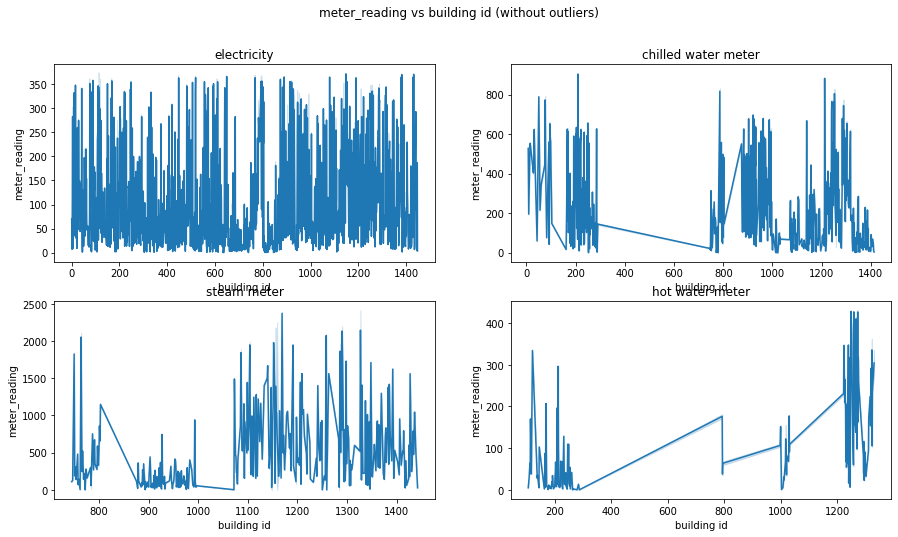

In [ ]:
# plotting building id vs meter reading for each meter type
fig,ax=plt.subplots(2,2,figsize=(15,8))
fig.suptitle("meter_reading vs building id (without outliers)")

# electricity meter
x1=cleaned_df[cleaned_df['meter']==0][['meter','meter_reading','building_id']]
sns.lineplot(ax=ax[0,0],x=list(x1.building_id),y=list(x1.meter_reading))
ax[0,0].set(title="electricity",xlabel='building id',ylabel='meter_reading')
ax
gc.collect()

# chilled water meter
x1=cleaned_df[cleaned_df['meter']==1][['meter','meter_reading','building_id']]
sns.lineplot(ax=ax[0,1],x=list(x1.building_id),y=list(x1.meter_reading))
ax[0,1].set(title="chilled water meter",xlabel='building id',ylabel='meter_reading')
gc.collect()

#steam meter
x1=cleaned_df[cleaned_df['meter']==2][['meter','meter_reading','building_id']]
sns.lineplot(ax=ax[1,0],x=list(x1.building_id),y=list(x1.building_id))
ax[1,0].set(title="steam meter",xlabel='building id',ylabel='meter_reading')
gc.collect()

# hot water meter
x1=cleaned_df[cleaned_df['meter']==3][['meter','meter_reading','building_id']]
sns.lineplot(ax=ax[1,1],x=list(x1.building_id),y=list(x1.meter_reading))
ax[1,1].set(title="hot water meter",xlabel='building id',ylabel='meter_reading')

plt.show()

Now we don't see any unusual spikes.

In [ ]:
# saving dataframe(outliers removed)
with open("/content/drive/MyDrive/cleaned_df.pkl","wb") as f:
  pickle.dump(cleaned_df,f)

In [ ]:
#converting meter readings and square feet value to logarathmic values
cleaned_df['meter_reading'] = np.log1p(cleaned_df['meter_reading'])
cleaned_df['square_feet'] = np.log1p(cleaned_df['square_feet'])

#resetting index
cleaned_df=cleaned_df.reset_index()


In [ ]:
# adding month, day and hour feature
cleaned_df['Month']=pd.DatetimeIndex(cleaned_df['timestamp']).month
cleaned_df['Day']=pd.DatetimeIndex(cleaned_df['timestamp']).day
cleaned_df['Hour']=pd.DatetimeIndex(cleaned_df['timestamp']).hour

# vectorizing primary_use
cleaned_df=pd.get_dummies(cleaned_df, columns=['primary_use'])

In [ ]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17532113 entries, 0 to 17532112
Data columns (total 31 columns):
 #   Column                                     Dtype         
---  ------                                     -----         
 0   index                                      int64         
 1   site_id                                    int8          
 2   building_id                                int16         
 3   square_feet                                float64       
 4   meter                                      int8          
 5   timestamp                                  datetime64[ns]
 6   meter_reading                              float32       
 7   air_temperature                            float16       
 8   dew_temperature                            float16       
 9   sea_level_pressure                         float16       
 10  wind_direction                             float16       
 11  wind_speed                                 float16       
 12

After removing of outliers train data contains more than 17.5 million data points.

In [ ]:
# dropping timestamp, sea_level_pressure, wind_direction and old index column
Featured_df=cleaned_df.drop(['timestamp','index','sea_level_pressure','wind_direction'],axis=1)

del cleaned_df

In [ ]:
print(Featured_df.head())

   building_id  square_feet  meter  meter_reading  air_temperature  \
0           46     9.110078      0       2.809677        19.406250   
1           74    12.867830      0       2.610340        19.406250   
2           93    10.415443      0       2.795113        19.406250   
3          105    10.832181      0       3.190624         3.800781   
4          106     8.589514      0       0.318163         3.800781   

   dew_temperature  wind_speed  Month  Day  Hour  ...  primary_use_Office  \
0        19.406250    0.000000      1    1     0  ...                   0   
1        19.406250    0.000000      1    1     0  ...                   0   
2        19.406250    0.000000      1    1     0  ...                   1   
3         2.400391    3.099609      1    1     0  ...                   0   
4         2.400391    3.099609      1    1     0  ...                   0   

   primary_use_Other  primary_use_Parking  primary_use_Public services  \
0                  0                    0 

In [ ]:
#saving the datafarme
with open("/content/drive/MyDrive/Featured_df.pkl","wb") as f:
  pickle.dump(Featured_df,f)

In [ ]:
#loading dataframe
with open("/content/drive/MyDrive/Featured_df.pkl","rb") as f:
  Featured_df=pickle.load(f)

In [ ]:
y=Featured_df.meter_reading
X=Featured_df.drop('meter_reading',axis=1)

In [ ]:
del Featured_df
gc.collect()

62

In [ ]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
del X,y

In [ ]:
# Basline model-LinearRegression
model=LinearRegression()
model.fit(X_train,y_train)


LinearRegression()

In [ ]:

#predicting test data and train data
y_predict_test=model.predict(X_test)
y_predict_train=model.predict(X_train)

#root mean squared error of test data and train data
print("RMSE of train data:",MSE(y_train,y_predict_train,squared=False))
print("RMSE of test data:",MSE(y_test,y_predict_test,squared=False))

RMSE of train data: 1.6644649643467249
RMSE of test data: 1.6662979002408054
